## Load Data

In [1]:
import sys
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix

# Pastikan root project ke sys.path
PROJECT_ROOT = Path("..").resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

from src.data_prep.clean_global_superstore import (
    load_raw_data,
    clean_global_superstore,
    encode_categoricals_and_process_for_model,
    save_clean_data,
    save_model_ready_data,
)
from src.eda.eda_utils import (
    plot_correlation_target,
    cramers_v,
    plot_target_cramers, 
)
from src.models.model_utils import (
    confusion_matrix_plot,
    feature_importance_plot,
    coefficient_plot,
    get_model_metrics
)

RAW_PATH = PROJECT_ROOT / "data" / "raw" / "Global_Superstore2.csv"
CLEAN_PATH = PROJECT_ROOT / "data" / "processed" / "global_superstore_clean.csv"
MODEL_READY_PATH = PROJECT_ROOT / "data" / "processed" / "global_superstore_model_ready.csv"

TARGET_COL = "is_profitable"
results_list = []

# --- Step 1: load / generate df_clean ---
if CLEAN_PATH.exists():
    print(f"[INFO] Load data bersih dari {CLEAN_PATH}")
    df_clean = pd.read_csv(
        CLEAN_PATH,
        parse_dates=["order_date", "ship_date"],
        low_memory=False,
    )
else:
    print(f"[INFO] File clean belum ada, load raw dari {RAW_PATH} lalu cleaning...")
    df_raw = load_raw_data(RAW_PATH)
    df_clean = clean_global_superstore(df_raw)
    save_clean_data(df_clean, CLEAN_PATH)

print("Shape df_clean:", df_clean.shape)

# --- Step 2: load / generate df_model (model-ready) ---
if MODEL_READY_PATH.exists():
    print(f"[INFO] Load model-ready dari {MODEL_READY_PATH}")
    df_model = pd.read_csv(MODEL_READY_PATH, low_memory=False)
else:
    print("[INFO] File model-ready belum ada, lakukan encoding dari df_clean...")
    df_model = encode_categoricals_and_process_for_model(df_clean)
    save_model_ready_data(df_model, MODEL_READY_PATH)

print("Shape df_model:", df_model.shape)



[INFO] Load data bersih dari /Users/afifahfq/Uni Materials/Pemrograman Data Analitik/Tubes/tubes-if5100-global-superstore/data/processed/global_superstore_clean.csv
Shape df_clean: (51290, 30)
[INFO] Load model-ready dari /Users/afifahfq/Uni Materials/Pemrograman Data Analitik/Tubes/tubes-if5100-global-superstore/data/processed/global_superstore_model_ready.csv
Shape df_model: (51290, 52)


In [2]:
df_model.head()

,sales,quantity,discount,shipping_cost,order_priority,order_year,order_month,order_quarter,shipping_days,sales_per_quantity,...,sub_category_Envelopes,sub_category_Fasteners,sub_category_Furnishings,sub_category_Labels,sub_category_Machines,sub_category_Paper,sub_category_Phones,sub_category_Storage,sub_category_Supplies,sub_category_Tables
0,2309.650,7,0.0,933.57,3,2012,7,3,0,329.950,...,False,False,False,False,False,False,False,False,False,False
1,3709.395,9,0.1,923.63,3,2013,2,1,2,412.155,...,False,False,False,False,False,False,False,False,False,False
2,5175.171,9,0.1,915.49,1,2013,10,4,1,575.019,...,False,False,False,False,False,False,True,False,False,False
3,2892.510,5,0.1,910.16,1,2013,1,1,2,578.502,...,False,False,False,False,False,False,True,False,False,False
4,2832.960,8,0.0,903.04,3,2013,11,4,1,354.120,...,False,False,False,False,False,False,False,False,False,False


In [3]:
# --- Step 3: pisahkan fitur & target ---
if TARGET_COL not in df_model.columns:
    raise ValueError(f"Kolom target '{TARGET_COL}' tidak ditemukan di df_model.")

X = df_model.drop(columns=[TARGET_COL])
y = df_model[TARGET_COL]

print("Jumlah fitur:", X.shape[1])
print("Contoh nama fitur:", list(X.columns[:10]))

Jumlah fitur: 51
Contoh nama fitur: ['sales', 'quantity', 'discount', 'shipping_cost', 'order_priority', 'order_year', 'order_month', 'order_quarter', 'shipping_days', 'sales_per_quantity']


## Target Variable Analysis

### Distribusi Target

Text(0, 0.5, 'Number of Orders')

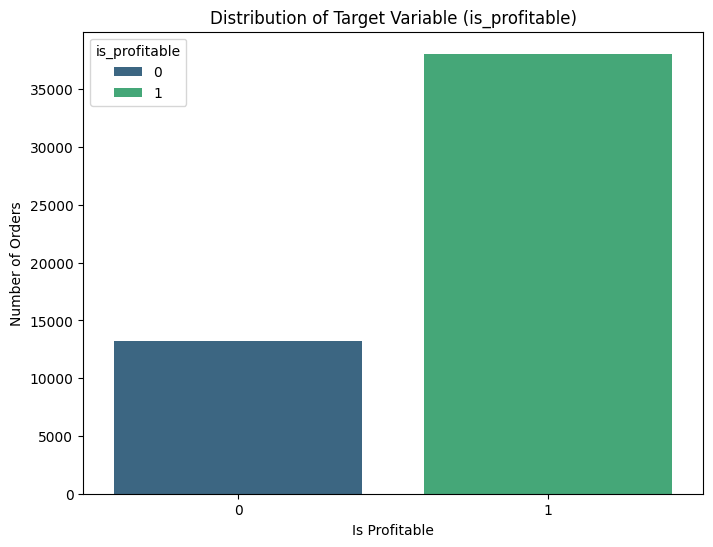

In [4]:
plt.figure(figsize=(8, 6))
sns.countplot(x=TARGET_COL, data=df_model, hue=TARGET_COL, palette='viridis')
plt.title('Distribution of Target Variable (is_profitable)')
plt.xlabel('Is Profitable')
plt.ylabel('Number of Orders')

### Korelasi fitur numerik dengan target

[INFO] Figure disimpan ke: /Users/afifahfq/Uni Materials/Pemrograman Data Analitik/Tubes/tubes-if5100-global-superstore/reports/figures/corr_target_heatmap.png


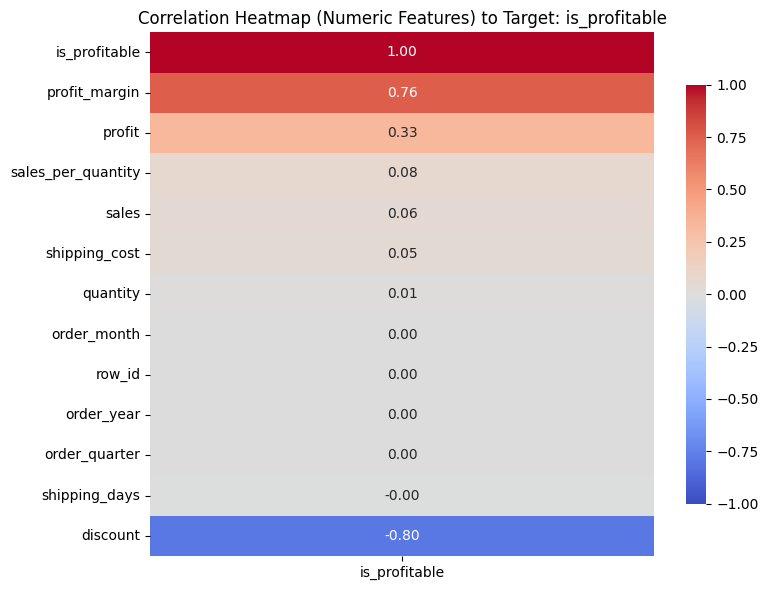

In [5]:
# Hitung korelasi target terhadap fitur numerik

corr = df_clean.corr(numeric_only=True)
corr_target = corr[TARGET_COL].sort_values(ascending=False)

_ = plot_correlation_target(
    df_clean,
    target_col=TARGET_COL,
    save_path="reports/figures/corr_target_heatmap.png",
)

### Korelasi fitur kategorikal dengan target

[INFO] Figure disimpan ke: /Users/afifahfq/Uni Materials/Pemrograman Data Analitik/Tubes/tubes-if5100-global-superstore/reports/figures/cramers_v_target.png


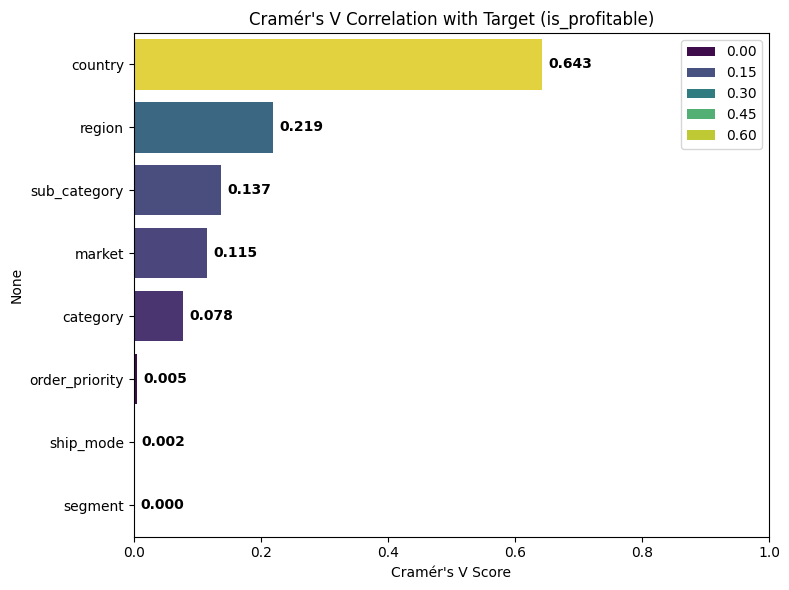

In [6]:
# Hitung korelasi Cramér's V target terhadap fitur kategorikal

_ = plot_target_cramers(
    df_clean,
    save_path="reports/figures/cramers_v_target.png",
)

## Data Preprocessing

### Split Data

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### Scaling

In [8]:
#  A must for some models, optional/good practice for all

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Convert to DF

In [9]:
# Convert to DataFrame to keep column names for the importance plot

X_train_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_df = pd.DataFrame(X_test_scaled, columns=X.columns)

## Model Training

### Decision Tree

In [10]:
dt_model = DecisionTreeClassifier(max_depth=10, min_samples_leaf=5, random_state=42)
dt_model.fit(X_train_scaled, y_train)

y_pred = dt_model.predict(X_test_scaled)

metrics = get_model_metrics(dt_model, "Decision Tree", X_test_scaled, y_test)
results_list.append(metrics)

print("--- Decision Tree Performance ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"F1 Score (Profitable): {f1_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

--- Decision Tree Performance ---
Accuracy: 0.9197
F1 Score (Profitable): 0.9472

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.78      0.83      2642
           1       0.93      0.97      0.95      7616

    accuracy                           0.92     10258
   macro avg       0.91      0.87      0.89     10258
weighted avg       0.92      0.92      0.92     10258



[INFO] Figure disimpan ke: /Users/afifahfq/Uni Materials/Pemrograman Data Analitik/Tubes/tubes-if5100-global-superstore/reports/figures/cm_decision_tree.png


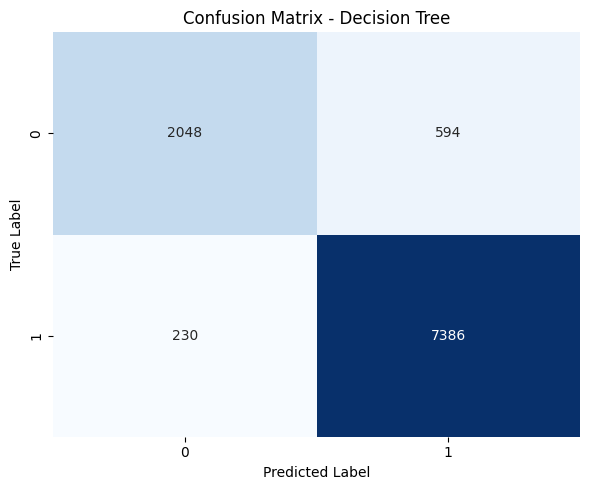

In [11]:
_ = confusion_matrix_plot(
    "Decision Tree",
    y_test,
    y_pred,
    save_path="reports/figures/cm_decision_tree.png",
)

[INFO] Figure disimpan ke: /Users/afifahfq/Uni Materials/Pemrograman Data Analitik/Tubes/tubes-if5100-global-superstore/reports/figures/fi_random_forest.png


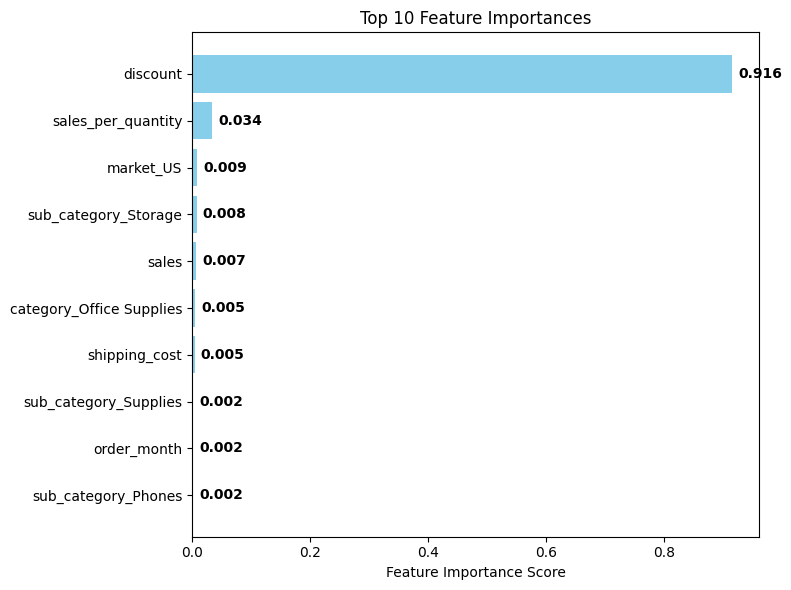

In [12]:
_ = feature_importance_plot(
    dt_model,
    X.columns.tolist(),
    top_n=10,
    save_path="reports/figures/fi_random_forest.png",
)

### Random Forest

In [13]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train_df, y_train)

y_pred = rf_model.predict(X_test_df)

metrics = get_model_metrics(rf_model, "Random Forest", X_test_df, y_test)
results_list.append(metrics)

print("--- Random Forest Performance ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"F1 Score (Profitable): {f1_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

--- Random Forest Performance ---
Accuracy: 0.9182
F1 Score (Profitable): 0.9461

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.78      0.83      2642
           1       0.93      0.97      0.95      7616

    accuracy                           0.92     10258
   macro avg       0.91      0.87      0.89     10258
weighted avg       0.92      0.92      0.92     10258



[INFO] Figure disimpan ke: /Users/afifahfq/Uni Materials/Pemrograman Data Analitik/Tubes/tubes-if5100-global-superstore/reports/figures/cm_random_forest.png


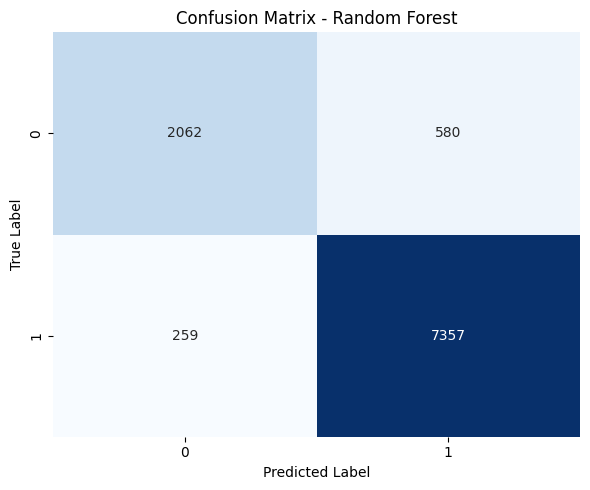

In [14]:
_ = confusion_matrix_plot(
    "Random Forest",
    y_test,
    y_pred,
    save_path="reports/figures/cm_random_forest.png",
)

[INFO] Figure disimpan ke: /Users/afifahfq/Uni Materials/Pemrograman Data Analitik/Tubes/tubes-if5100-global-superstore/reports/figures/fi_random_forest.png


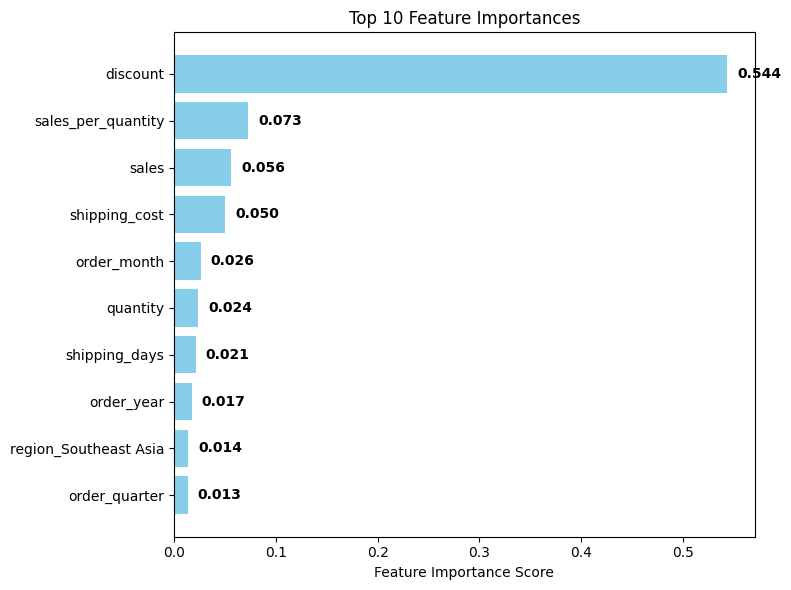

In [15]:
_ = feature_importance_plot(
    rf_model,
    X_train_df.columns.tolist(),
    top_n=10,
    save_path="reports/figures/fi_random_forest.png",
)

### Gradient Boosting

In [16]:
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gb_model.fit(X_train_df, y_train)

y_pred = gb_model.predict(X_test_df)

metrics = get_model_metrics(gb_model, "Gradient Boosting", X_test_df, y_test)
results_list.append(metrics)

print("--- Gradient Boosting Performance ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"F1 Score (Profitable): {f1_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

--- Gradient Boosting Performance ---
Accuracy: 0.9197
F1 Score (Profitable): 0.9473

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.77      0.83      2642
           1       0.92      0.97      0.95      7616

    accuracy                           0.92     10258
   macro avg       0.91      0.87      0.89     10258
weighted avg       0.92      0.92      0.92     10258



[INFO] Figure disimpan ke: /Users/afifahfq/Uni Materials/Pemrograman Data Analitik/Tubes/tubes-if5100-global-superstore/reports/figures/cm_gradient_boosting.png


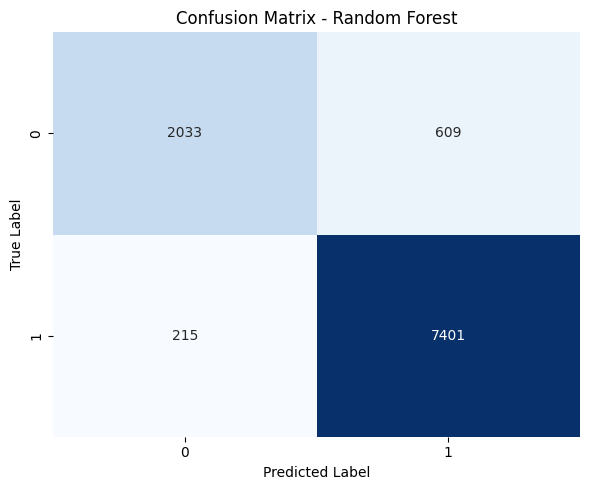

In [17]:
_ = confusion_matrix_plot(
    "Random Forest",
    y_test,
    y_pred,
    save_path="reports/figures/cm_gradient_boosting.png",
)

[INFO] Figure disimpan ke: /Users/afifahfq/Uni Materials/Pemrograman Data Analitik/Tubes/tubes-if5100-global-superstore/reports/figures/fi_gradient_boosting.png


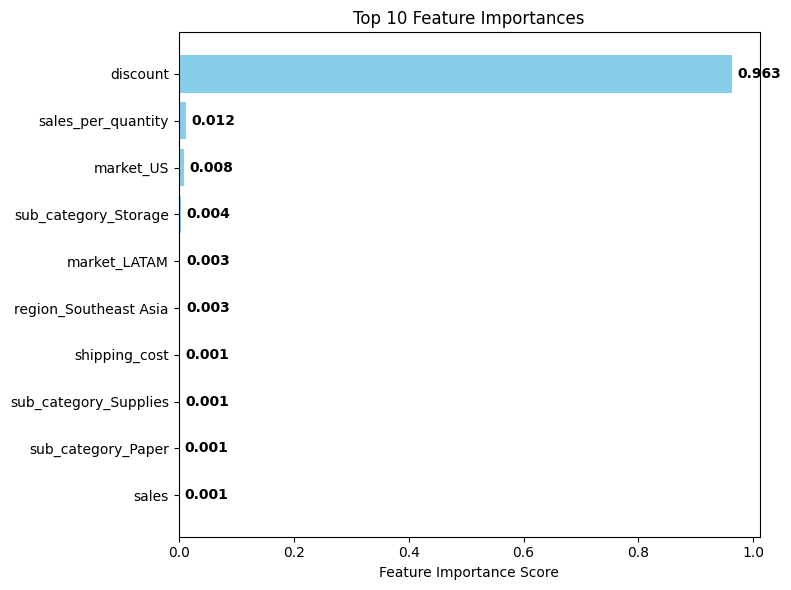

In [18]:
_ = feature_importance_plot(
    gb_model,
    X_train_df.columns.tolist(),
    top_n=10,
    save_path="reports/figures/fi_gradient_boosting.png",
)

### Ensemble Models

Using Voting Classifier

In [19]:
clf1 = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=42)
clf2 = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
clf3 = GradientBoostingClassifier(n_estimators=100, random_state=42)

voting_model = VotingClassifier(
    estimators=[
        ('lr', clf1), 
        ('rf', clf2), 
        ('gb', clf3)
    ],
    voting='soft'
)
voting_model.fit(X_train_df, y_train)

y_pred = voting_model.predict(X_test_df)

metrics = get_model_metrics(voting_model, "Ensemble (Voting)", X_test_df, y_test)
results_list.append(metrics)

print("--- Ensemble (Voting) Performance ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"F1 Score (Profitable): {f1_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

--- Ensemble (Voting) Performance ---
Accuracy: 0.9186
F1 Score (Profitable): 0.9460

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.80      0.83      2642
           1       0.93      0.96      0.95      7616

    accuracy                           0.92     10258
   macro avg       0.90      0.88      0.89     10258
weighted avg       0.92      0.92      0.92     10258



[INFO] Figure disimpan ke: /Users/afifahfq/Uni Materials/Pemrograman Data Analitik/Tubes/tubes-if5100-global-superstore/reports/figures/cm_voting_ensemble.png


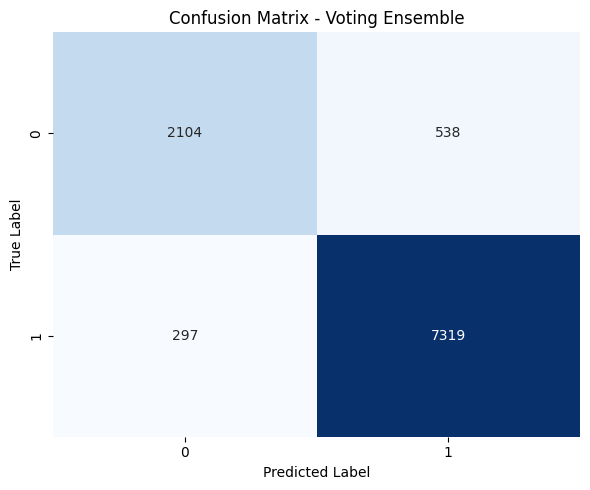

In [20]:
_ = confusion_matrix_plot(
    "Voting Ensemble",
    y_test,
    y_pred,
    save_path="reports/figures/cm_voting_ensemble.png",
)

### Logistic Regression

In [21]:
logreg = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=42)
logreg.fit(X_train_df, y_train)

y_pred = logreg.predict(X_test_df)

metrics = get_model_metrics(logreg, "Logistic Regression", X_test_df, y_test)
results_list.append(metrics)

print("--- Logistic Regression Performance ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"F1 Score (Profitable): {f1_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

--- Logistic Regression Performance ---
Accuracy: 0.9084
F1 Score (Profitable): 0.9377

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.85      0.83      2642
           1       0.95      0.93      0.94      7616

    accuracy                           0.91     10258
   macro avg       0.88      0.89      0.88     10258
weighted avg       0.91      0.91      0.91     10258



[INFO] Figure disimpan ke: /Users/afifahfq/Uni Materials/Pemrograman Data Analitik/Tubes/tubes-if5100-global-superstore/reports/figures/cm_logistic_regression.png


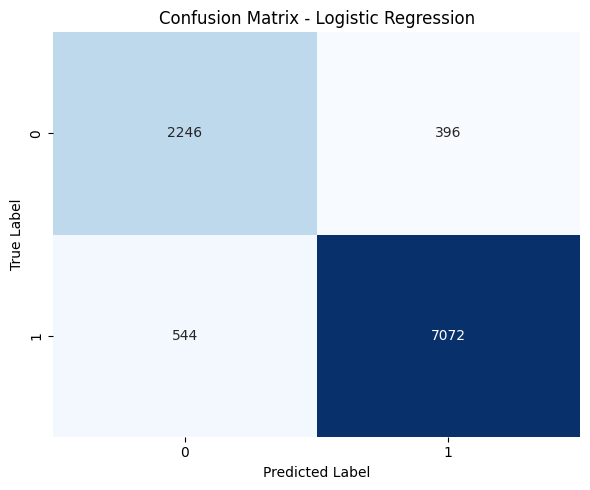

In [22]:
_ = confusion_matrix_plot(
    "Logistic Regression",
    y_test,
    y_pred,
    save_path="reports/figures/cm_logistic_regression.png",
)

[INFO] Figure disimpan ke: /Users/afifahfq/Uni Materials/Pemrograman Data Analitik/Tubes/tubes-if5100-global-superstore/reports/figures/logreg_coefficients.png


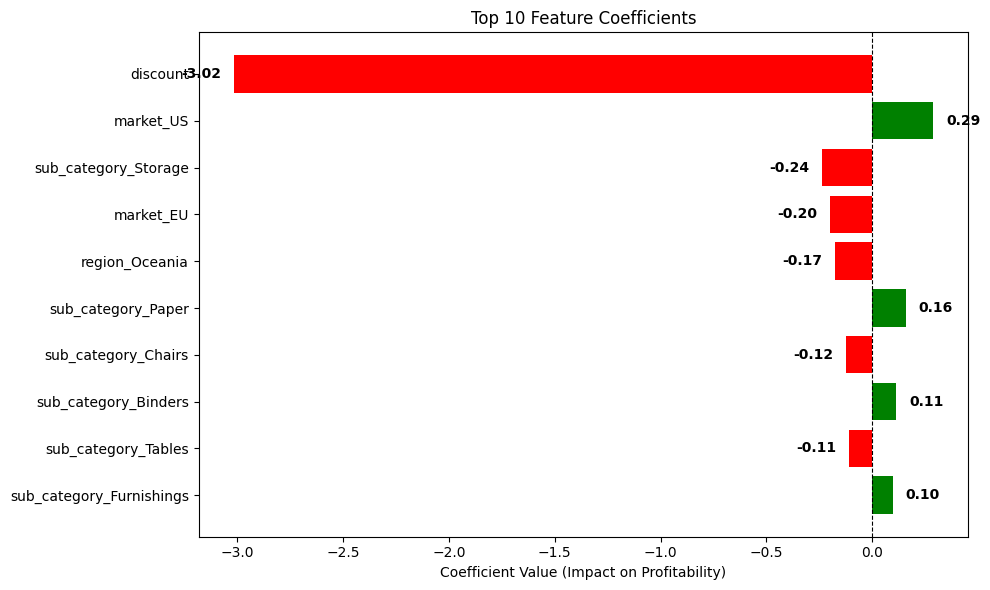

In [23]:
_ = coefficient_plot(
    logreg,  # Your trained Logistic Regression model
    X_train_df.columns.tolist(),
    top_n=10,
    save_path="reports/figures/logreg_coefficients.png"
)
plt.show()

Using grid search

In [24]:
logreg = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42)

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']
}

f1_unprofitable_scorer = make_scorer(f1_score, pos_label=0)

grid_search = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid,
    cv=5,
    scoring=f1_unprofitable_scorer,
    verbose=1,
    n_jobs=-1 
)

grid_search.fit(X_train, y_train)

print("\n--- Best Parameters Found ---")
print(grid_search.best_params_)
print(f"Best CV F1-Score (Unprofitable): {grid_search.best_score_:.4f}")

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

metrics = get_model_metrics(best_model, "Logistic Regression (Tuned)", X_test_df, y_test)
results_list.append(metrics)

print("\n--- Test Set Performance (Best Model) ---")
print(classification_report(y_test, y_pred, target_names=['Unprofitable (0)', 'Profitable (1)']))

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/Users/afifahfq/Uni Materials/Pemrograman Data Analitik/Tubes/tubes-if5100-global-superstore/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/afifahfq/Uni Materials/Pemrograman Data Analitik/Tubes/tubes-if5100-global-superstore/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/afifahfq/Uni Materials/Pemrograman Data Analitik/Tubes/tubes-if5100-global-superstore/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/afifahfq/Uni Materials/Pemrograman Data Analitik/Tubes/tubes-if5100-global-superstore/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of i


--- Best Parameters Found ---
{'C': 0.001, 'penalty': 'l1'}
Best CV F1-Score (Unprofitable): 0.8319

--- Test Set Performance (Best Model) ---
                  precision    recall  f1-score   support

Unprofitable (0)       0.90      0.77      0.83      2642
  Profitable (1)       0.92      0.97      0.95      7616

        accuracy                           0.92     10258
       macro avg       0.91      0.87      0.89     10258
    weighted avg       0.92      0.92      0.92     10258



[INFO] Figure disimpan ke: /Users/afifahfq/Uni Materials/Pemrograman Data Analitik/Tubes/tubes-if5100-global-superstore/reports/figures/cm_logistic_regression_grid_search.png


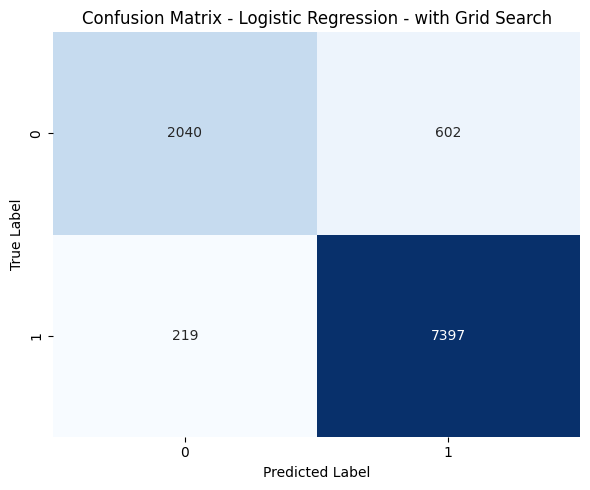

In [25]:
_ = confusion_matrix_plot(
    "Logistic Regression - with Grid Search",
    y_test,
    y_pred,
    save_path="reports/figures/cm_logistic_regression_grid_search.png",
)

[INFO] Figure disimpan ke: /Users/afifahfq/Uni Materials/Pemrograman Data Analitik/Tubes/tubes-if5100-global-superstore/reports/figures/logreg_coefficients_grid_search.png


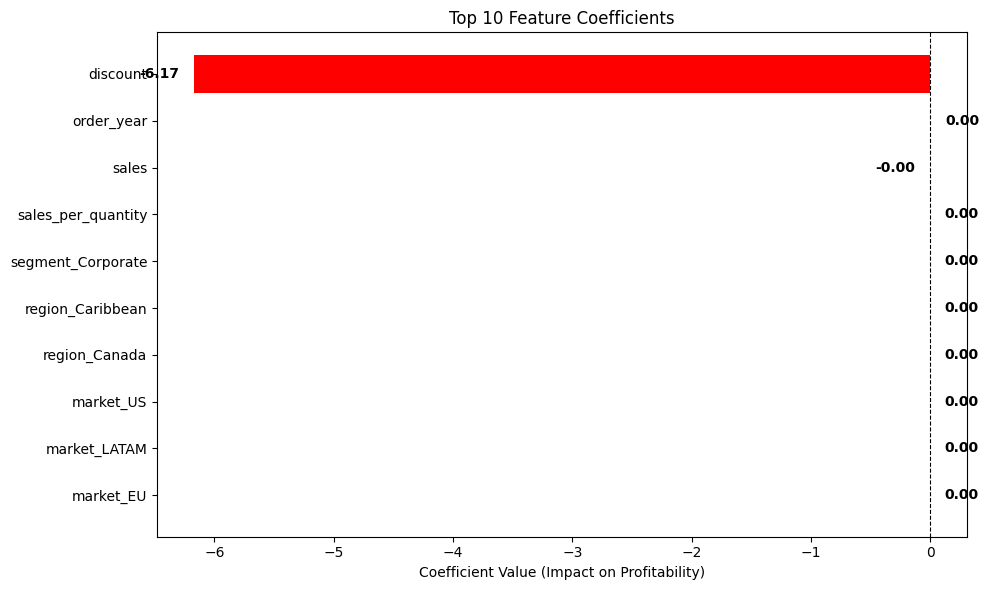

In [26]:
_ = coefficient_plot(
    best_model, 
    X_train_df.columns.tolist(),
    top_n=10,
    save_path="reports/figures/logreg_coefficients_grid_search.png"
)
plt.show()

### SVM
Using LinearSVC

In [27]:
svm_model = LinearSVC(class_weight='balanced', random_state=42, dual='auto', max_iter=2000)
svm_model.fit(X_train_df, y_train)

y_pred = svm_model.predict(X_test_df)

metrics = get_model_metrics(svm_model, "Linear SVM", X_test_df, y_test)
results_list.append(metrics)

print("--- Linear SVM Performance ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"F1 Score (Profitable): {f1_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

--- Linear SVM Performance ---
Accuracy: 0.9128
F1 Score (Profitable): 0.9414

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83      2642
           1       0.94      0.94      0.94      7616

    accuracy                           0.91     10258
   macro avg       0.89      0.88      0.89     10258
weighted avg       0.91      0.91      0.91     10258



[INFO] Figure disimpan ke: /Users/afifahfq/Uni Materials/Pemrograman Data Analitik/Tubes/tubes-if5100-global-superstore/reports/figures/cm_logistic_regression_grid_search.png


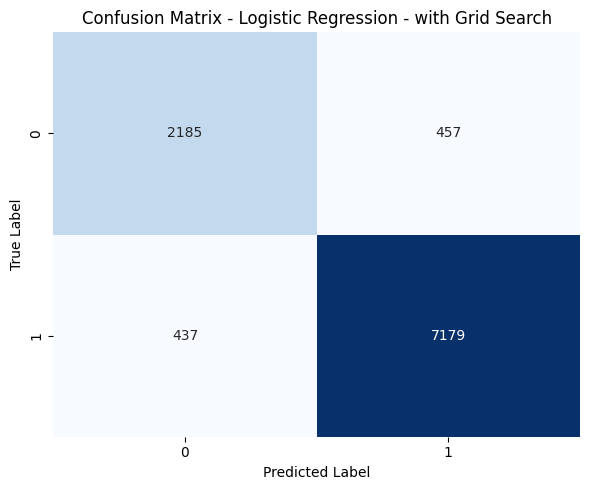

In [28]:
_ = confusion_matrix_plot(
    "Logistic Regression - with Grid Search",
    y_test,
    y_pred,
    save_path="reports/figures/cm_logistic_regression_grid_search.png",
)

[INFO] Figure disimpan ke: /Users/afifahfq/Uni Materials/Pemrograman Data Analitik/Tubes/tubes-if5100-global-superstore/reports/figures/logreg_coefficients_grid_search.png


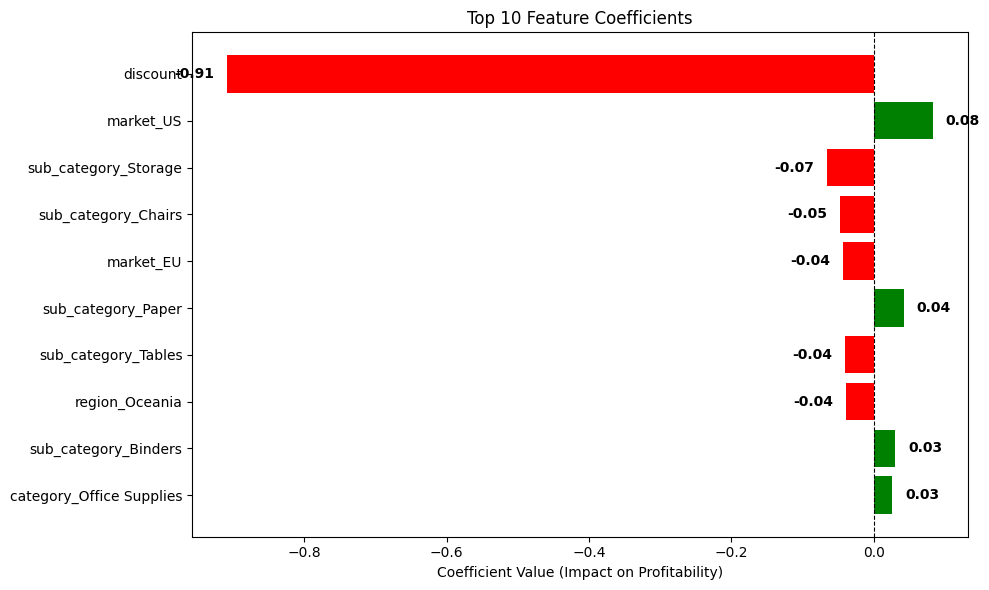

In [29]:
_ = coefficient_plot(
    svm_model, 
    X_train_df.columns.tolist(),
    top_n=10,
    save_path="reports/figures/logreg_coefficients_grid_search.png"
)
plt.show()

## Model Evaluation

In [30]:
models_dict = {
    "Logistic Regression": logreg,
    "Decision Tree": dt_model,
    "Random Forest": rf_model,
    "Gradient Boosting": gb_model,
    "Voting Ensemble": voting_model,
    "Linear SVM": svm_model
}

In [31]:
leaderboard_df = pd.DataFrame(results_list)
leaderboard_df = leaderboard_df.sort_values(by="F1 (Unprofitable)", ascending=False)

print("\n--- Final Model Leaderboard ---")
display(leaderboard_df) 


--- Final Model Leaderboard ---


,Model,Accuracy,F1 (Unprofitable),Recall (Unprofitable),Precision (Unprofitable),F1 (Profitable)
3,Ensemble (Voting),0.918600,0.834424,0.796366,0.876302,0.946035
0,Decision Tree,0.919672,0.832520,0.775170,0.899034,0.947166
2,Gradient Boosting,0.919672,0.831493,0.769493,0.904359,0.947267
1,Random Forest,0.918210,0.830949,0.780469,0.888410,0.946055
6,Linear SVM,0.912849,0.830167,0.827025,0.833333,0.941385
4,Logistic Regression,0.908364,0.826951,0.850114,0.805018,0.937682
5,Logistic Regression (Tuned),0.857575,0.762863,0.889478,0.667803,0.898224


Fokus terhadap skor untuk prediksi value Unprofitable, karena umumnya jika melihat dari value Profitable tidak terlihat perubahan yg signifikan diantara model yang baik dan yg buruk.

Dari hasil diatas, ditemukan bahwa model Ensemble (Voting) adalah model yang terbaik. Model tersebut menghasilkan F1-Score tertinggi untuk Unprofitable dengan nilai 0.8344. Model juga berhasil memprediksi dengan Precision 0.8763.

Model ini terbaik dan wise pada real-life case, karena dapat memprediksi hampir semua order rugi, tapi lebih cerdas dalam mengenali order yang untung sehingga hampir tidak akan menuduh order yang menguntungkan.

Dan ditemukan bahwa model terbaik kedua adalah Linear SVM. Dengan nilai Recall 0.827 dapat mengidentifikasi data buruk lebih baik dibadingkan Ensemble dan Gradient Boosting, dan tetap memiliki nilai Accuracy yg baik yaitu 0.9128.

Dalam real-life case, model ini sangat strict, dan akan menemukan banyak order rugi dan jarang salah prediksi dengan menolak order yang untung.

Model yang perlu dihindari adalah Logistic Regression karena walaupun memiliki nilai Recall tertinggi yaitu 0.89, tetapi memiliki Accuracy yg paling buruk yaitu 0.85 dan Precision yang jauh lebih buruk dibandingkan yang lain yaitu 0.667.

Dalam real-life case, model ini akan bersikap paraniod dimana hampir menangkap semua order rugi, tapi akan menangkap juga banyak order yang untung jika dilihat risky.